In [12]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np

In [4]:
deseases = pd.read_csv("large_data.csv")
deseases.head()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,...,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
0,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,ALLERGY
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,1,ALLERGY
2,0,1,1,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,ALLERGY
3,0,0,0,1,1,0,0,0,0,0,...,0,1,1,0,0,1,0,1,1,ALLERGY
4,0,0,1,0,1,0,0,0,0,0,...,0,1,1,0,1,0,1,1,1,ALLERGY


In [41]:
flu = deseases[deseases.TYPE == "FLU"].drop(columns=["TYPE"])
covid = deseases[deseases.TYPE == "COVID"].drop(columns=["TYPE"])
cold = deseases[deseases.TYPE == "COLD"].drop(columns=["TYPE"])
allergy = deseases[deseases.TYPE == "ALLERGY"].drop(columns=["TYPE"])

## Flu

<BarContainer object of 20 artists>

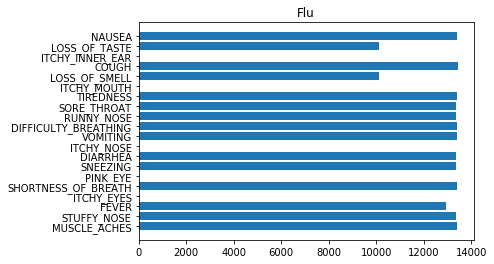

In [53]:
flu_dict = flu.sum().to_dict()
#plt.xlim([0, 10])
plt.title("Flu")
plt.barh(flu_dict.keys(), flu_dict.values())

## Covid

<BarContainer object of 20 artists>

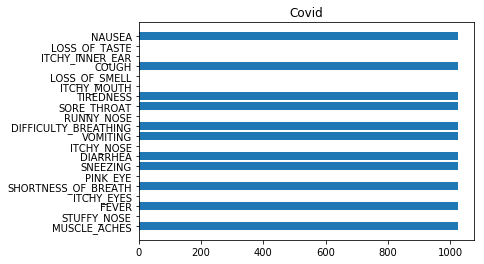

In [51]:
covid_dict = covid.sum().to_dict()
#plt.xlim([0, 10])
plt.title("Covid")
plt.barh(covid_dict.keys(), covid_dict.values())

## Cold

<BarContainer object of 20 artists>

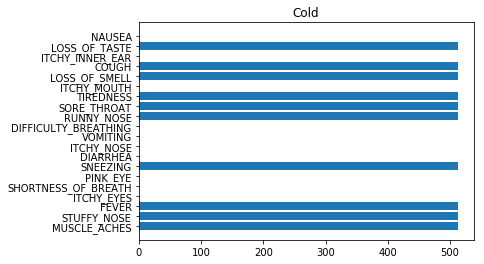

In [50]:
cold_dict = cold.sum().to_dict()
#plt.xlim([0, 10])
plt.title("Cold")
plt.barh(cold_dict.keys(), cold_dict.values())

## Allergy

<BarContainer object of 20 artists>

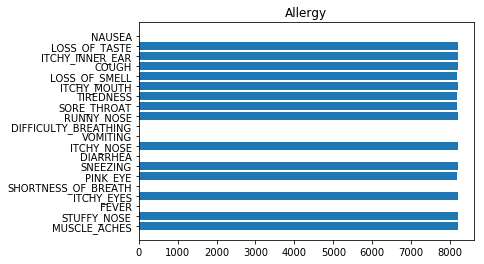

In [49]:
allergy_dict = allergy.sum().to_dict()
#plt.xlim([0, 10])
plt.title("Allergy")
plt.barh(allergy_dict.keys(), allergy_dict.values())

## All deaseases

<BarContainer object of 20 artists>

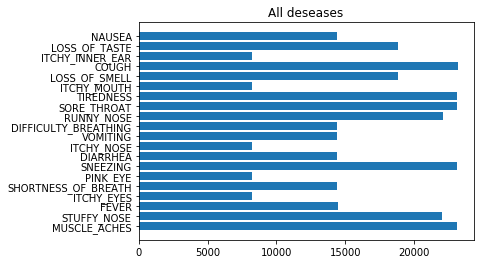

In [48]:
deseases_dict = deseases.drop(columns=["TYPE"]).sum().to_dict()
#plt.xlim([0, 10])
plt.title("All deseases")
plt.barh(deseases_dict.keys(), deseases_dict.values())